In [1]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN

%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/default-of-credit-card-clients.csv')
df = df.rename(columns={"PAY_0": "PAY_1"}, errors="raise")
df.drop(columns=['ID'],inplace=True)

In [44]:
len(df)

30000

## Partitioning

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV


def split_data(X,y, random_state=42):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                        stratify= y, random_state=random_state)
    return X_train, X_test, y_train, y_test

y, X = df["default payment next month"], df.drop("default payment next month", axis=1)

random_state = 42
ts = 0.25

X_train, X_test, y_train, y_test = split_data(X, y)

## Scaling + Boxplots

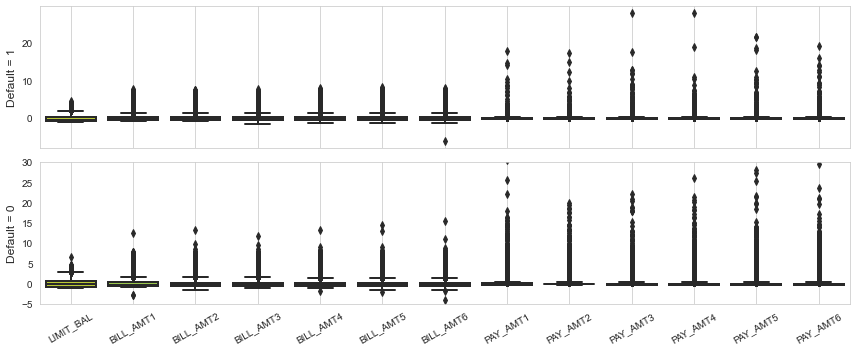

In [4]:
X_train_reduced = X_train.drop(columns=["SEX","MARRIAGE","EDUCATION","AGE",
                                       "PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"])

train_mean, train_std = X_train_reduced.mean(0), X_train_reduced.std(0)
X_train_scaled = (X_train_reduced - train_mean) / train_std
X_test_scaled = (X_train_reduced - train_mean) / train_std

fig, axs = plt.subplots(2,1,figsize = (12,5), sharex= True)
sns.boxplot(data = X_train_scaled[y_train == 1], palette="viridis_r", linewidth=2, ax = axs[0], whis= 1.5)
sns.boxplot(data = X_train_scaled[y_train == 0], palette="viridis_r", linewidth=2, ax = axs[1], whis= 1.5)

y_labels = ["Default = 1","Default = 0"]
for ax,y_label in zip(axs,y_labels):
    ax.grid()
    ax.set_ylabel(y_label, fontsize=12)
    
plt.xticks(rotation=30)  
plt.ylim(-5,30)
plt.tight_layout()

plt.savefig('../images/09-boxplot-data.svg')

plt.show()

## PCA

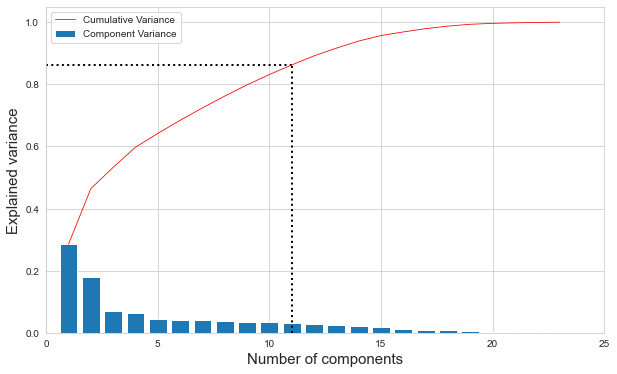

In [62]:
from sklearn.decomposition import PCA


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0,25)

pca = PCA(n_components= X_train_scaled.shape[1], random_state=random_state)
X_train_reduced = pca.fit_transform(X_train_scaled)

ax.bar(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_, 
        label="Component Variance",
        )
ax.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Variance",
         linewidth = 0.8
        )

plt.vlines(x=11, ymin=0, ymax=0.863, colors='black', ls=':', lw=2)
plt.hlines(y=0.863, xmin=0, xmax=11, colors='black', ls=':', lw=2)

ax.set_ylabel('Explained variance', fontdict= {"size":15})
ax.set_xlabel('Number of components', fontdict= {"size":15})
ax.legend(loc='upper left')
plt.savefig('../images/10-PCA.svg')
plt.show()

# add annotations??

In [ ]:
cs = np.cumsum(pca.explained_variance_ratio_)
threshold = .85
mask = cs < threshold
n = sum(mask) + 1
pca_scores = {}
pca_gs_trained_models = {}

## Resampling

### Random Under-Sampling

In [13]:
# under = RandomUnderSampler(sampling_strategy=0.6, random_state=random_state)
under = NearMiss(version=3)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

### Over Sampling

In [8]:
over = SMOTE(sampling_strategy=0.5)
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)

len(X_train_over) / len(X_train)

1.5576

In [9]:
len(X_train)

22500

### Combination of under- and over-sampling

In [10]:
smote_enn = SMOTEENN(0.77,random_state=random_state)
X_train_under_over, y_train_under_over = smote_enn.fit_resample(X_train, y_train)



In [18]:
over = SMOTE()
X_train_over, y_train_over = over.fit_resample(X_train, y_train)

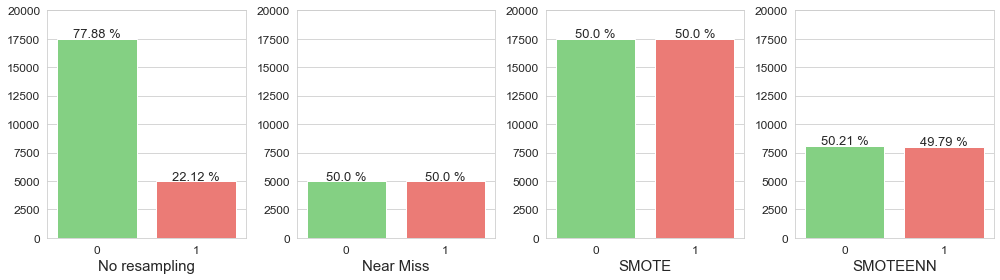

In [19]:
len(X_train_over) / len(X_train)

y_list = [y_train, y_train_under, y_train_over, y_train_under_over]
y_list_labels = ['No resampling', 'Near Miss', 'SMOTE', 'SMOTEENN']

plt.figure(figsize=(14,4))

i = 1
for value, label in zip(y_list,y_list_labels):    
    plt.subplot(1,4,i)
    graph_target = sns.countplot(value, palette=['#77DD76','#FF6962'])
    plt.xlabel(label, fontdict= {"size":15})
    plt.ylabel('')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # annotate?
    
    j=0
    for p in graph_target.patches:
        height = p.get_height()

        str_plot = f'{round(100 * value.value_counts()[j]/len(value),2)} %'

        graph_target.text(p.get_x()+p.get_width()/2., height + 100 , str_plot, ha="center", fontsize = 13)
        j += 1
        
    i += 1
    graph_target.set_ylim(0, 20000) 

plt.tight_layout()
plt.savefig('../images/12-resampling-02.svg')
plt.show()

In [ ]:
## .72 -> 54 | 45
## .73 -> 52 | 47
## .75 -> 51 | 48
## .77 -> 50.21
## .7745 -> 49.66
## .7748 -> 49.77
## .7749 -> 49.91
## .775 -> 49.97
## .7752 -> 49.81
## .7751 ->49.92